### Conditional Varation Autoencoder

![General schema](./images/Conditional-variational-autoencoder-scheme.png)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Lambda, Flatten, Reshape, Input, BatchNormalization, Dropout, concatenate

Нейросеть автоэнкодера на самом деле является парой из двух соединенных нейросетей – энкодера и декодера. Энкодер принимает входные данные и преобразует их, делая представление более компактным и сжатым. В свою очередь, декодер использует преобразованные данные для трансформации их обратно в оригинальное состояние.

В случае, если вы незнакомы с энкодерами, но знаете о свёрточных нейронных сетях (Convolutional Neural Networks — CNNs), то, по сути, вы уже знаете, что делает автоэнкодер.

![](./images/encoder.jpg)

In [2]:
#model constants
hidden_dim = 2
num_classes = 10
batch_size = 100  # должно быть кратно 60 000 и 10 0000

In [3]:
#Optimization for each layer

def dropout_and_batch(x):
  return Dropout(0.3)(BatchNormalization()(x))

In [4]:
#Create encoder
input_img = Input(shape=(28, 28, 1))
fl = Flatten()(input_img)
lb = Input(shape=(num_classes,))
x = concatenate([fl, lb])
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)

In [5]:
#Create vectors of mean and log variance
# for each latent variable

z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)
def noiser(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
  return K.exp(z_log_var / 2) * N + z_mean

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])

In [6]:
# Create decoder
input_dec = Input(shape=(hidden_dim,))
lb_dec = Input(shape=(num_classes,))
d = concatenate([input_dec, lb_dec])
d = Dense(128, activation='elu')(d)
d = dropout_and_batch(d)
d = Dense(256, activation='elu')(d)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

In [7]:
# Define CVAE model
encoder = keras.Model([input_img, lb], h, name='encoder')
decoder = keras.Model([input_dec, lb_dec], decoded, name='decoder')
cvae = keras.Model([input_img, lb, lb_dec], decoder([encoder([input_img, lb]), lb_dec]), name="cvae")

z_meaner = keras.Model([input_img, lb], z_mean2)
tr_style = keras.Model([input_img, lb, lb_dec], decoder([z_meaner([input_img, lb]), lb_dec]), name='tr_style')

NameError: name 'z_mean2' is not defined

In [ ]:
#Loss function
def vae_loss(x, y):
  x = K.reshape(x, shape=(batch_size, 28*28))
  y = K.reshape(y, shape=(batch_size, 28*28))
  loss = K.sum(K.square(x-y), axis=-1)
  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  return loss + kl_loss

In [ ]:
cvae.compile(optimizer='adam', loss=vae_loss)

In [ ]:
# Define training and testing data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# стандартизация входных данных
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

cvae.fit(x_train, x_train, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 100.1317
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 48.0814
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 45.2401
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 43.9215
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 43.4126


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


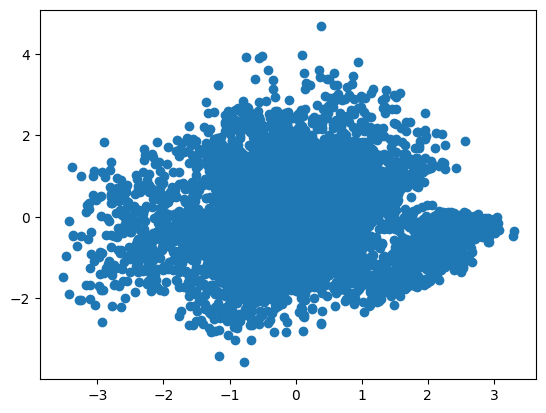

In [ ]:
# Plot latent space
lb = lb_dec = y_test_cat
h = encoder.predict([x_test, lb], batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━

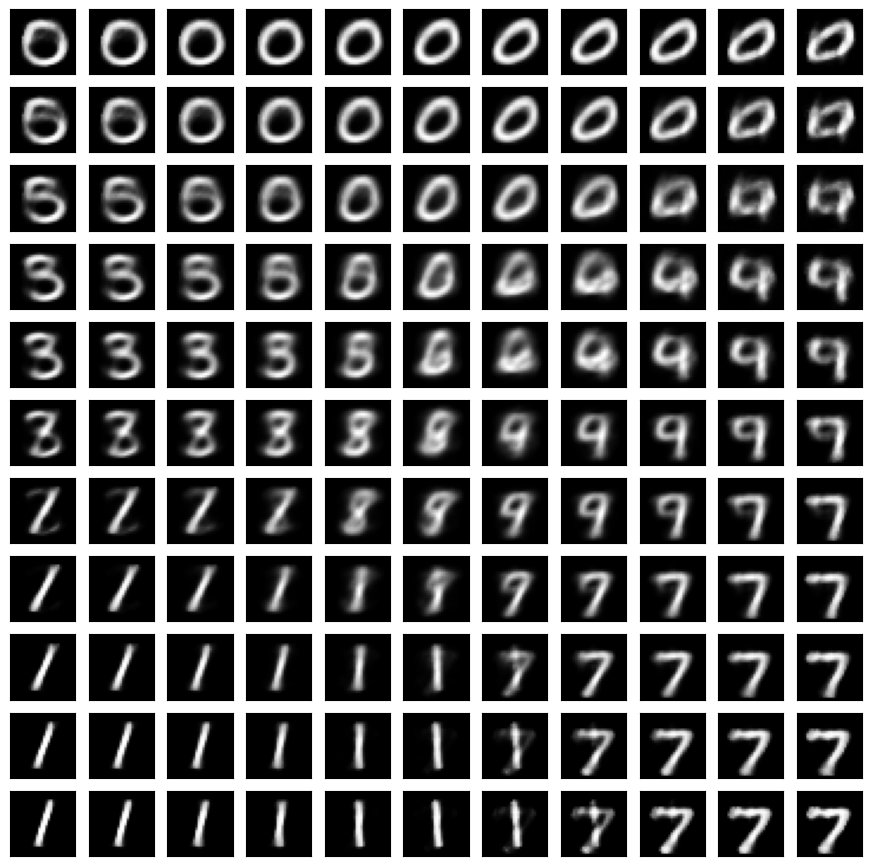

In [ ]:
# Plotting the results
n = 4
total = 2*n+1
input_lbl = np.zeros((1, num_classes))
input_lbl[0, 5] = 1

plt.figure(figsize=(total, total))

h = np.zeros((1, hidden_dim))
num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    h[0, :] = [1*i/n, 1*j/n]
    img = decoder.predict([h, input_lbl])
    plt.imshow(img.squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


def plot_digits(*images):
    images = [x.squeeze() for x in images]
    n = min([x.shape[0] for x in images])
    
    plt.figure(figsize=(n, len(images)))
    for j in range(n):
        for i in range(len(images)):
            ax = plt.subplot(len(images), n, i*n + j + 1)
            plt.imshow(images[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

dig1 = 5
dig2 = 2

num = 10
X = x_train[y_train == dig1][:num]

lb_1 = np.zeros((num, num_classes))
lb_1[:, dig1] = 1

plot_digits(X)

for i in range(num_classes):
  lb_2 = np.zeros((num, num_classes))
  lb_2[:, i] = 1

  Y = tr_style.predict([X, lb_1, lb_2], batch_size=num)
  plot_digits(Y)